<a href="https://colab.research.google.com/github/7atemAlawwad/T5/blob/main/MiniProject_last_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
---
# Time Series Forecasting
---
---

# Importing libraries

In [142]:
#!pip install mplfinance

In [143]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

About Dataset



Context



Air Passengers per month. Workshop dataset**

**Loading** **Data**

In [144]:
df = pd.read_csv('AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [146]:
df.rename(columns={'Month': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

In [147]:
df.isna().sum()

,0
Date,0
#Passengers,0


In [148]:
df.shape

(144, 2)

In [149]:
df

,Date,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [150]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter
df['Lag_1'] = df['#Passengers'].shift(1)
df['Rolling_Mean'] = df['#Passengers'].rolling(window=3).mean()
df.dropna(inplace=True)

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 142 entries, 2 to 143
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          142 non-null    datetime64[ns]
 1   #Passengers   142 non-null    int64         
 2   Year          142 non-null    int32         
 3   Month         142 non-null    int32         
 4   Quarter       142 non-null    int32         
 5   Lag_1         142 non-null    float64       
 6   Rolling_Mean  142 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int32(3), int64(1)
memory usage: 7.2 KB


## Visualization

We convert the date column to the right format and visualize some of the time series to explore patterns and seasonality

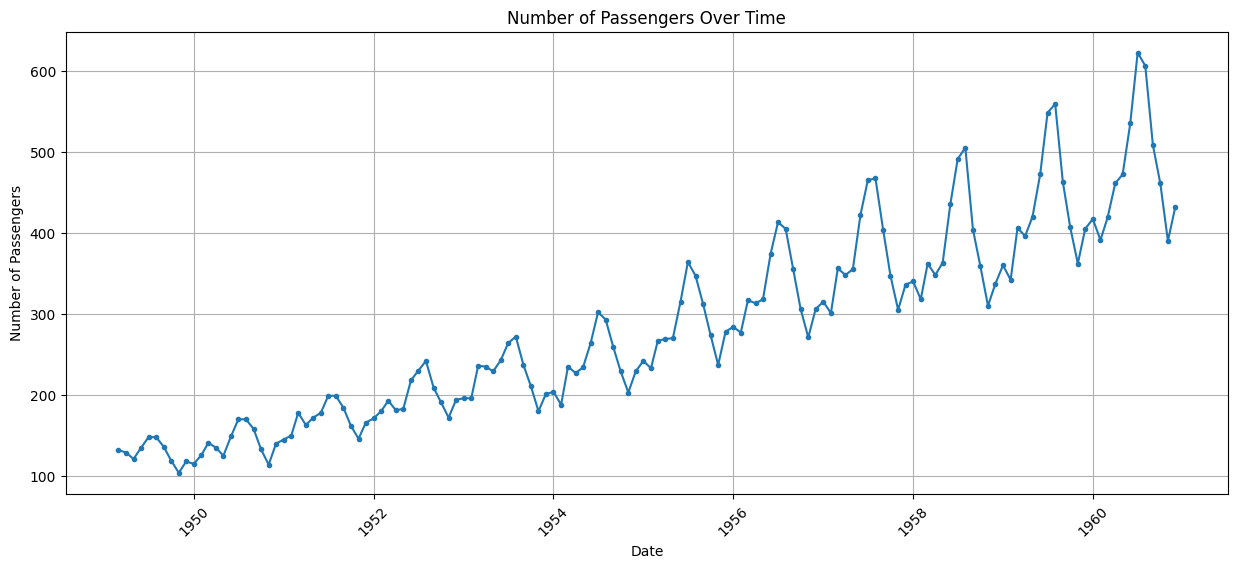

In [152]:
plt.figure(figsize=(15, 6))
plt.plot(df['Date'], df['#Passengers'], marker='.')
plt.title('Number of Passengers Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

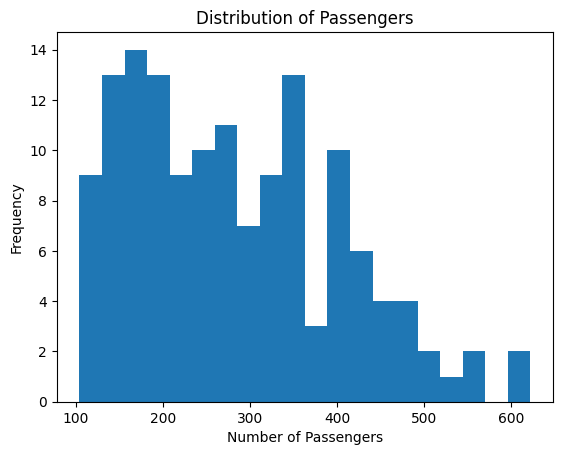

In [153]:
df['#Passengers'].plot(kind='hist', bins=20)
plt.title('Distribution of Passengers')
plt.xlabel('Number of Passengers')
plt.ylabel('Frequency')
plt.show()

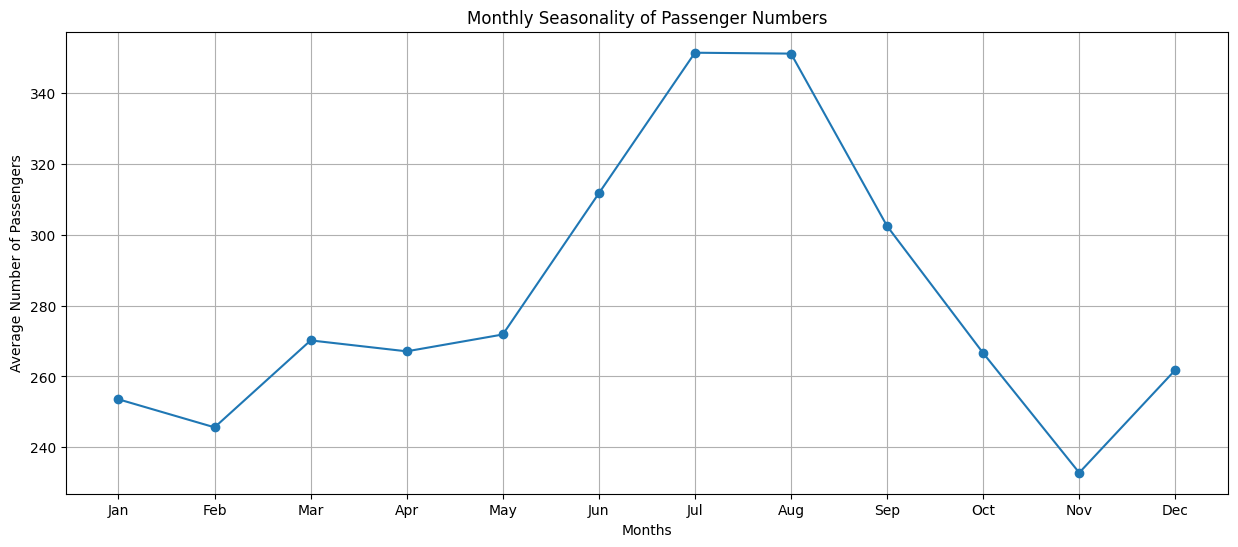

In [154]:
# Extract the month from the 'Date' column

# Calculate the monthly average number of passengers
monthly_average = df.groupby('Month')['#Passengers'].mean()

# Plotting the monthly seasonality
plt.figure(figsize=(15, 6))
plt.plot(monthly_average.index, monthly_average.values, marker='o')
plt.title('Monthly Seasonality of Passenger Numbers')
plt.xlabel('Months')
plt.ylabel('Average Number of Passengers')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

<Axes: ylabel='Frequency'>

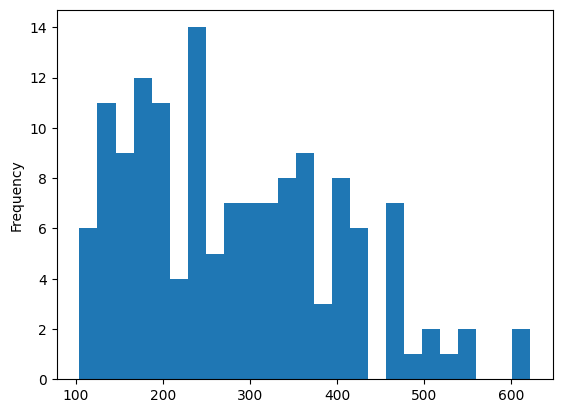

In [155]:
df['#Passengers'].plot.hist(bins=25)

Normalize the values

In [156]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

## Data Splitting
Note the data is **not** being randomly shuffled before splitting. This is for two reasons:


In [157]:
X = df[['Month', 'Year', 'Quarter', 'Lag_1', 'Rolling_Mean']].values
y = df['#Passengers'].values.reshape(-1, 1)

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)



In [158]:
sequence_length = 24

def create_sequences(data, target, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = target[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [159]:
# Generate sequences
X_train, y_train = create_sequences(X_scaled[:-sequence_length], y_scaled[:-sequence_length], sequence_length)
X_test, y_test = create_sequences(X_scaled[-(len(y_scaled) - sequence_length):], y_scaled[-(len(y_scaled) - sequence_length):], sequence_length)


In [160]:
# Build the LSTM model with correct input shape
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=100))
model.add(Dropout(0.3))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary to check the parameters
model.summary()


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                       │ (None, 24, 100)             │          42,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 24, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_37 (LSTM)                       │ (None, 24, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 24, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_38 (LSTM)                       │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 203,301 (794.14 KB)

 Trainable params: 203,301 (794.14 KB)

 Non-trainable params: 0 (0.00 B)

In [161]:
checkpoint_filepath = 'best_model.keras'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [162]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

In [163]:
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.1,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - loss: 0.0856
Epoch 1: val_loss improved from inf to 0.01473, saving model to best_model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - loss: 0.0628 - val_loss: 0.0147
Epoch 2/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0244
Epoch 2: val_loss did not improve from 0.01473
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0182 - val_loss: 0.0574
Epoch 3/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0121
Epoch 3: val_loss did not improve from 0.01473
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0187 - val_loss: 0.0455
Epoch 4/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0116
Epoch 4: val_loss did not improve from 0.01473
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0123 - val_loss: 0.0157
Epoch 5/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0118
Epoch 5: val_loss did not improve from 0.01473
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0128 - val_loss: 0.0157
Epoch 6/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/st

In [164]:
y_pred = model.predict(X_test)

y_pred = y_pred.reshape(-1, 1)

y_pred = scaler_y.inverse_transform(y_pred)
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


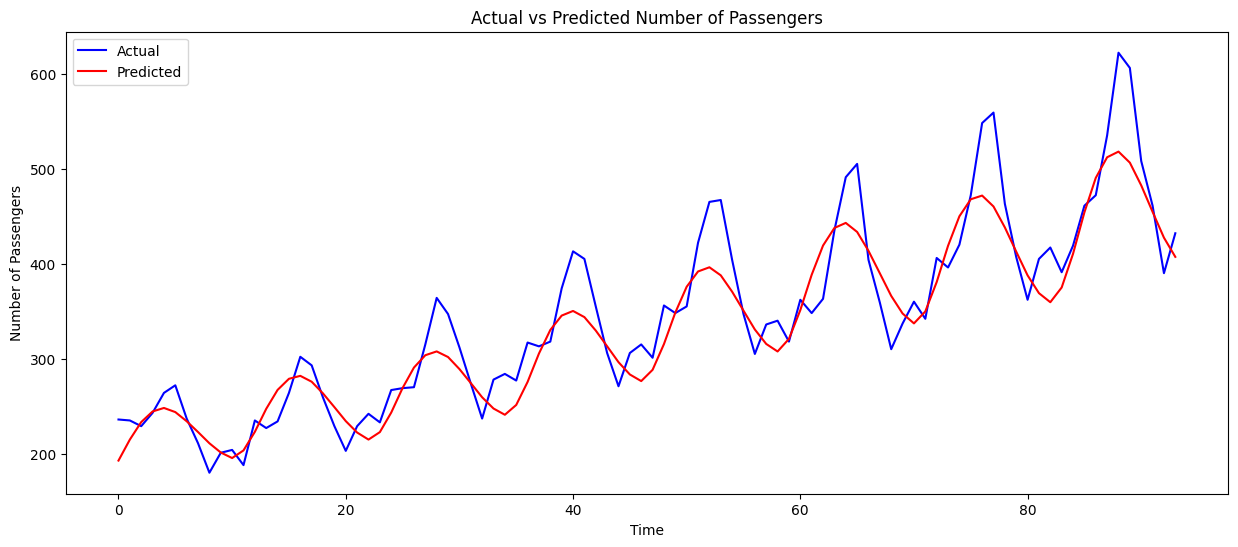

In [165]:
plt.figure(figsize=(15, 6))
plt.plot(y_test_actual, color='blue', label='Actual')
plt.plot(y_pred, color='red', label='Predicted')
plt.title('Actual vs Predicted Number of Passengers')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

In [166]:
mse = mean_squared_error(y_test_actual, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1246.3343856246508


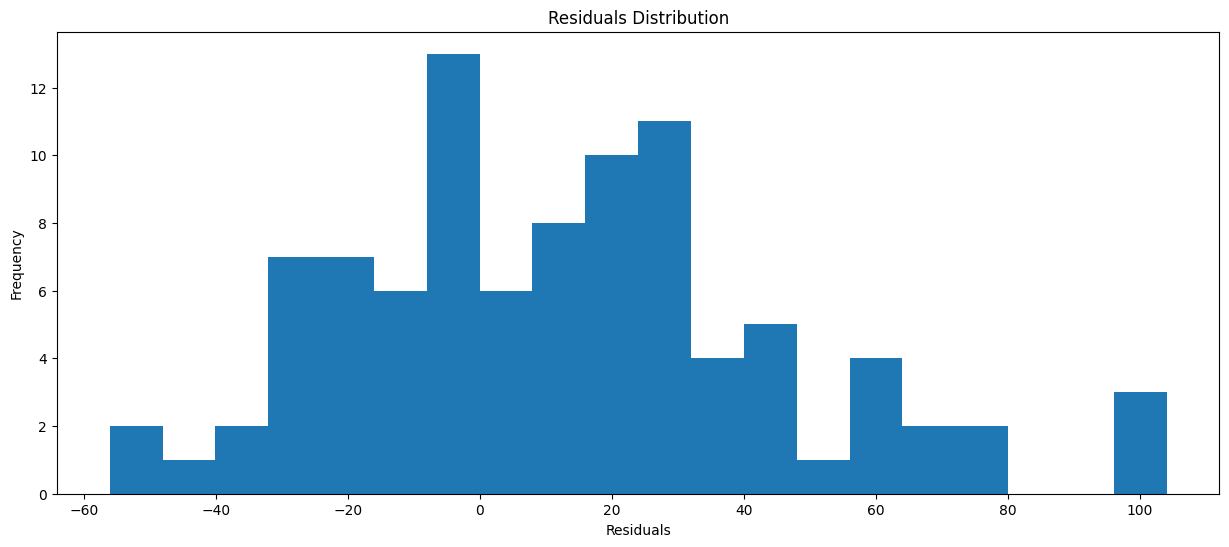

In [167]:
residuals = y_test_actual - y_pred
plt.figure(figsize=(15, 6))
plt.hist(residuals, bins=20)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()